<a href="https://colab.research.google.com/github/lovelyoyrmia/Foedtra/blob/main/Machine%20Learning/foedtra_modelv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Foedtra Transfer Learning Model V.1

Mounting google drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import os

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
  
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

Load data

In [ ]:
root_path = '/content/drive/MyDrive/Capstone Project - Foedtra'
labels = os.path.join(root_path, 'new_df', 'train_images.xlsx')
sample = os.path.join(root_path, 'new_df', 'test_images.xlsx')

train_path = os.path.join(root_path, 'dataset', 'train')
test_path = os.path.join(root_path, 'dataset','test')

#### Processing dataframe

In [ ]:
def rename_path_images(name, labels, dirs):
  return os.path.join(os.path.join('/content/drive/MyDrive/Capstone Project - Foedtra/dataset', dirs, labels), name)

In [ ]:
train_df = pd.read_excel(labels)
test_df = pd.read_excel(sample)
dev_df = pd.read_excel(os.path.join(root_path, 'new_df','dev_images.xlsx'))

In [ ]:
train_df['Filepath'] = train_df.apply(lambda x: rename_path_images(x['Filepath'], x['Label'], 'train'), axis=1)
test_df['Filepath'] = test_df.apply(lambda x: rename_path_images(x['Filepath'], x['Label'], 'test'), axis=1)

In [ ]:
len(list(train_df['Label'].unique()))

34

### Create Generator

In [ ]:
train_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
)

test_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
)

### Image augmentation

In [ ]:
train_images = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
)

Found 920 validated image filenames belonging to 34 classes.
Found 230 validated image filenames belonging to 34 classes.
Found 331 validated image filenames belonging to 34 classes.


Show Image generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

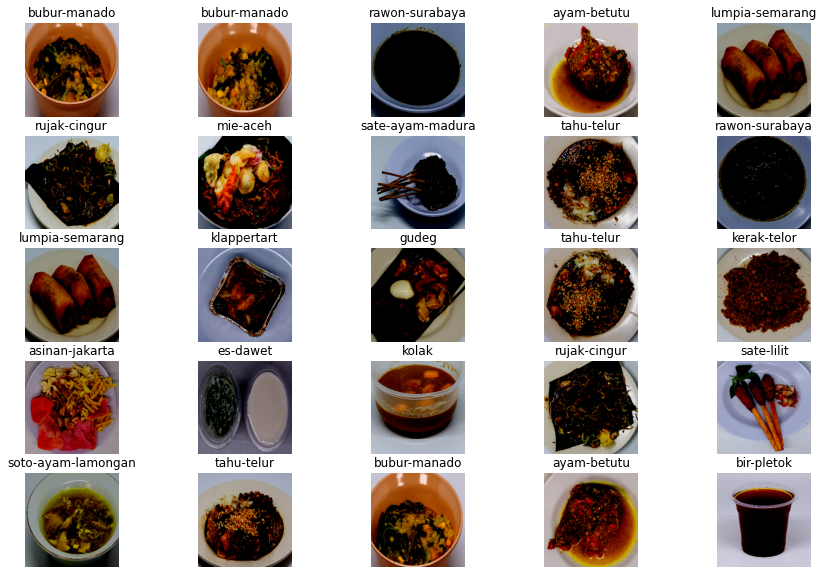

In [ ]:
a = train_images.class_indices
class_names = list(a.keys())
  
def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(25):
      plt.subplot(5,5,i+1)
      plt.imshow(img[i])
      plt.title(class_names[np.argmax(labels[i])])
      plt.axis('off')
    plt.show()

x, y = next(test_images)
plot_images(x,y)

## Modeling

In [ ]:
pretrained_model = tf.keras.applications.InceptionResNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
)

pretrained_model.trainable = False

model = Sequential([
      pretrained_model,
      BatchNormalization(renorm=True),
      GlobalAveragePooling2D(),
      Dense(512, activation='relu'),
      Dense(256, activation='relu'),
      Dropout(0.5),
      Dense(128, activation='relu'),
      Dense(34, activation='softmax')
])

219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 5, 5, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [ ]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)

In [ ]:
batch_size=32
STEP_SIZE_TRAIN = train_images.n//train_images.batch_size
STEP_SIZE_VALID = val_images.n//val_images.batch_size
  
# fit model
history = model.fit(train_images,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_images,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[early])

Epoch 1/25
28/28 [==============================] - 527s 18s/step - loss: 2.7588 - accuracy: 0.2883 - val_loss: 1.3203 - val_accuracy: 0.6830
Epoch 2/25
28/28 [==============================] - 106s 4s/step - loss: 0.8391 - accuracy: 0.7658 - val_loss: 0.1603 - val_accuracy: 0.9777
Epoch 3/25
28/28 [==============================] - 107s 4s/step - loss: 0.2535 - accuracy: 0.9324 - val_loss: 0.0438 - val_accuracy: 0.9911
Epoch 4/25
28/28 [==============================] - 105s 4s/step - loss: 0.1065 - accuracy: 0.9741 - val_loss: 0.0373 - val_accuracy: 0.9866
Epoch 5/25
28/28 [==============================] - 109s 4s/step - loss: 0.0663 - accuracy: 0.9854 - val_loss: 0.0118 - val_accuracy: 0.9955
Epoch 6/25
28/28 [==============================] - 105s 4s/step - loss: 0.0410 - accuracy: 0.9887 - val_loss: 0.0118 - val_accuracy: 0.9955
Epoch 7/25
28/28 [==============================] - 108s 4s/step - loss: 0.0366 - accuracy: 0.9887 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 8/25
2

## Evalute and Predict the Model

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9988738894462585\nValidation Accuracy: 1.0')

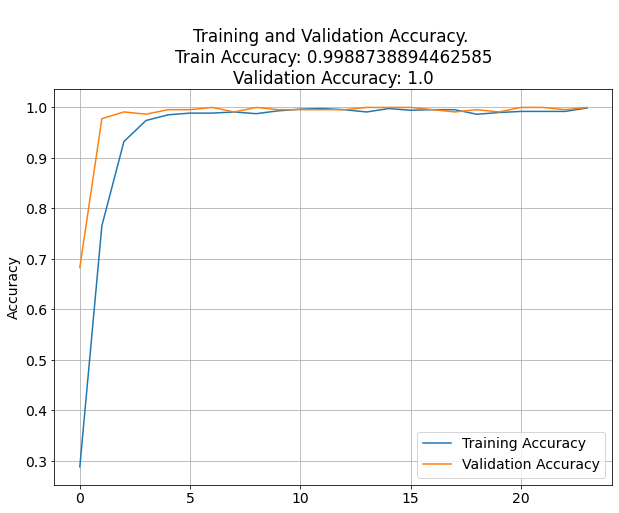

In [ ]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
  
  
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

In [ ]:
model.save('foedtra_model1.h5')

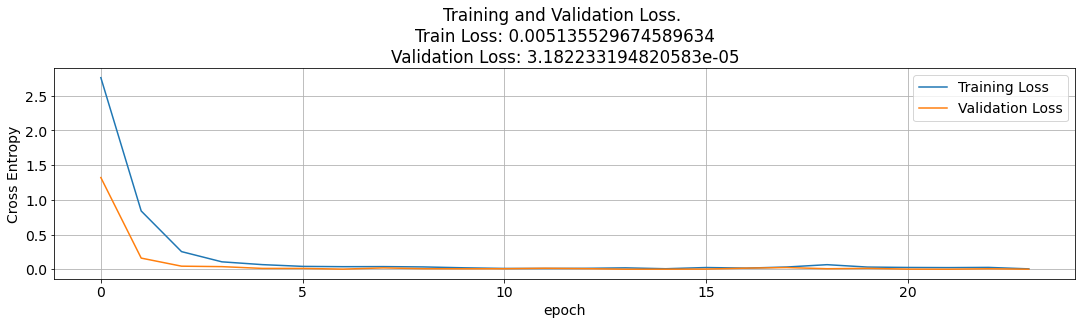

In [ ]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
accuracy_score = model.evaluate(val_images)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 
  
print("Loss: ",accuracy_score[0])

8/8 [==============================] - 24s 3s/step - loss: 1.2574e-04 - accuracy: 1.0000
[0.0001257361873285845, 1.0]
Accuracy: 100.0000%
Loss:  0.0001257361873285845


In [ ]:
results = model.evaluate(test_images, verbose=0)
print('Test Accuracy: {:.2f}%'.format(results[1] * 100))

Test Accuracy: 100.00%


In [ ]:
def predict_model_from_dir():
  predictions = []
    
  for image in test_df['Filepath']:
      img = tf.keras.preprocessing.image.load_img(image)
      img = tf.keras.preprocessing.image.img_to_array(img)
      img = tf.keras.preprocessing.image.smart_resize(img, (224, 224))
      img = tf.reshape(img, (-1, 224, 224, 3))
      prediction = model.predict(img/255)
      prediction = np.argmax(prediction)
      prediction = class_names[prediction]
      predictions.append(prediction)

  return predictions
  
my_submission = pd.DataFrame({'image_id': test_df['Filepath'], 'label':  predictions})
my_submission.to_excel('submission.xlsx', index=False, header=True)
  
# Submission file ouput
print("Submission File: \n---------------\n")
print(my_submission.head())

Submission File: 
---------------

                                            image_id             label
0  /content/drive/MyDrive/Capstone Project - Foed...       klappertart
1  /content/drive/MyDrive/Capstone Project - Foed...        tahu-telur
2  /content/drive/MyDrive/Capstone Project - Foed...     sate-maranggi
3  /content/drive/MyDrive/Capstone Project - Foed...        tahu-telur
4  /content/drive/MyDrive/Capstone Project - Foed...  pempek-palembang


In [ ]:
predicted_model = pd.read_excel('submission.xlsx')

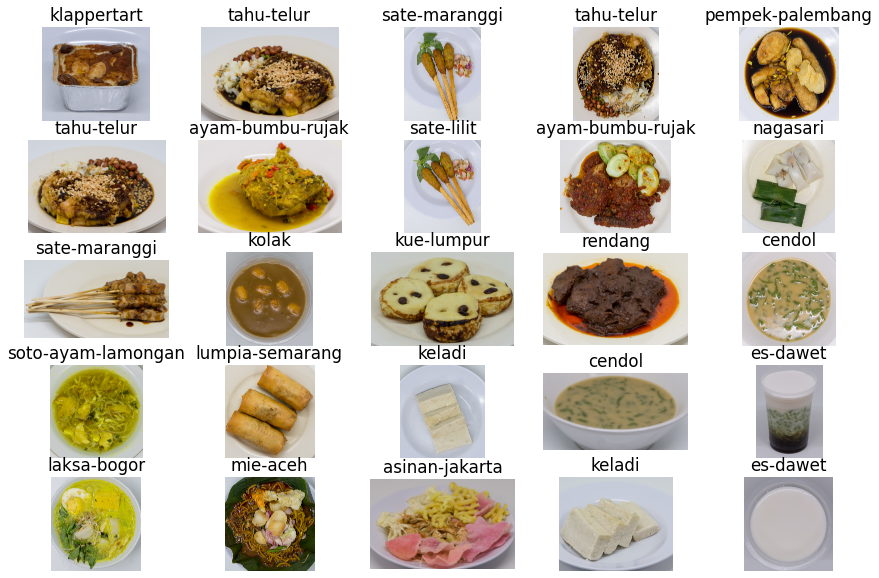

In [ ]:
plt.figure(figsize=[15,10])
for i in range(25):
  plt.subplot(5,5,i+1)
  image_test = plt.imread(predicted_model['image_id'][i])
  plt.imshow(image_test)
  plt.title(predicted_model['label'][i])
  plt.axis('off')
plt.show()

In [ ]:
def predict_image(path_image):
  img = tf.keras.preprocessing.image.load_img(path_image)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.preprocessing.image.smart_resize(img, (224, 224))
  img = tf.reshape(img, (-1, 224, 224, 3))
  prediction = model.predict(img/255)
  prediction = np.argmax(prediction)
  prediction = class_names[prediction]
  plt.title(prediction)
  img = plt.imread(path_image)
  plt.imshow(img)
  plt.show()

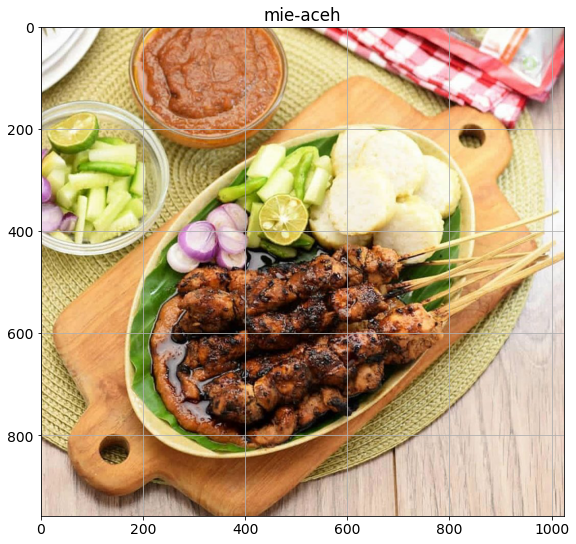

In [ ]:
predict_image()

### Visualisation predicted model

In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)
cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions)

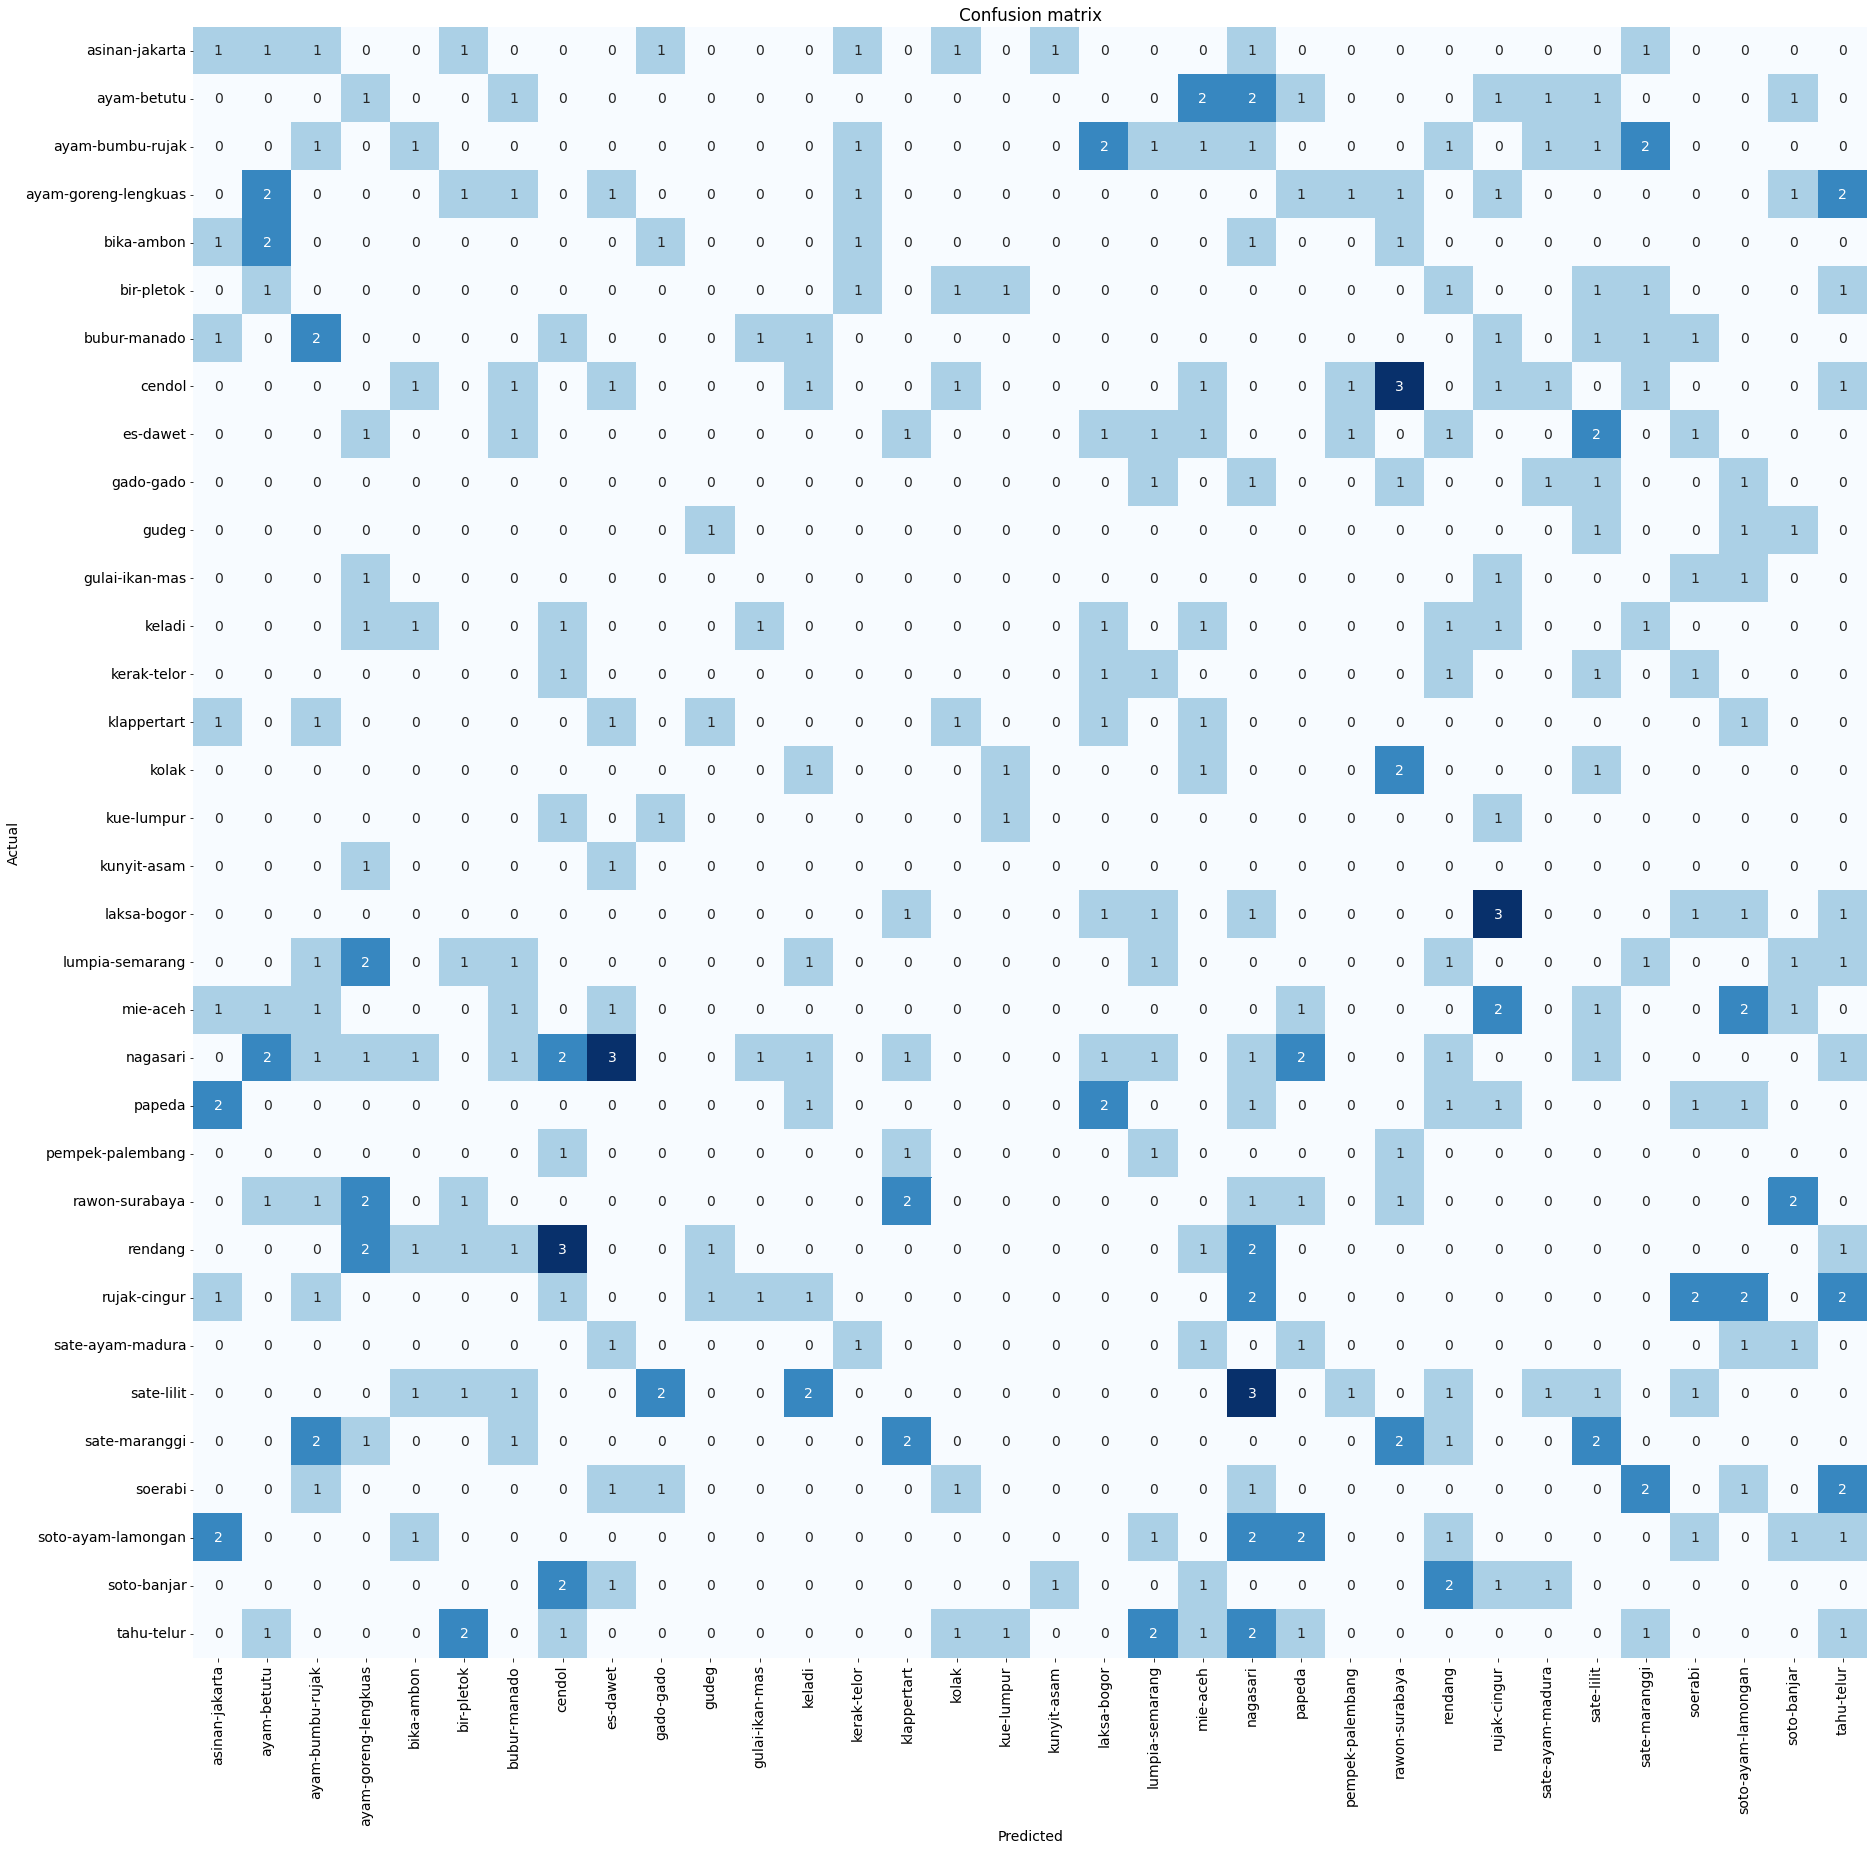

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(34) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(34) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [ ]:
print('Classification report:\n---------------------\n', clr)

Classification report:
---------------------
               precision    recall  f1-score   support

           0       0.10      0.10      0.10        10
           1       0.00      0.00      0.00        11
           2       0.08      0.08      0.08        13
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00         6
          10       0.25      0.25      0.25         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         9
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         8
          15       0.00      0.00      0.00         6
          16       0.25      0.25  